# Training with increased $N_{data}$

In [1]:
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# setup general info on batch sizes and img sizes
batch_size = 32
img_height = 256
img_width = 256

In [3]:
# taken from tf tutorial, unknown what this does so far
AUTOTUNE = tf.data.AUTOTUNE

In [4]:
datadir = os.path.join('..', 'Data', 'Cars')

In [5]:
# generate training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    datadir,
    validation_split= 0.2, # let the program know what the validation split will be in order to choose the correct size of this training set as well
    subset="training", # here we denote that this set will be the *training* set.
    seed=123,
    image_size = (img_height, img_width), # rescale images automatically
    batch_size= batch_size
) 

# randomly shuffle your data.
train_ds_pref = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# automatic labelling with this object, based on dict names.
class_names = train_ds.class_names

Found 31638 files belonging to 5 classes.
Using 25311 files for training.


In [6]:
# generate validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    datadir,
    validation_split= 0.2,
    subset="validation", # here we denote that this set will be the *validation* set.
    seed=123, 
    image_size = (img_height, img_width),
    batch_size= batch_size
)

# function of this line is currently unknown.
val_ds_pref = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 31638 files belonging to 5 classes.
Using 6327 files for validation.


In [7]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

In [8]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [9]:
from tensorflow.keras.layers import Dropout

In [10]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation, # data augmentation as a very first step
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2), # here we perform the dropout.
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [11]:
# compile the model
model.compile(optimizer='adam', # choose the optimizer
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # loss function is same as error function
              metrics=['accuracy']) # choose which metrics to keep track of during optimization

In [12]:
epochs = 15
history = model.fit(
  train_ds_pref,
  validation_data=val_ds_pref,
  epochs=epochs
)

Epoch 1/15
791/791 [==============================] - 631s 710ms/step - loss: 1.6055 - accuracy: 0.2383 - val_loss: 1.5931 - val_accuracy: 0.2613
Epoch 2/15
791/791 [==============================] - 619s 782ms/step - loss: 1.5659 - accuracy: 0.2811 - val_loss: 1.5415 - val_accuracy: 0.3139
Epoch 3/15
791/791 [==============================] - 596s 753ms/step - loss: 1.5321 - accuracy: 0.3066 - val_loss: 1.4926 - val_accuracy: 0.3463
Epoch 4/15
791/791 [==============================] - 585s 740ms/step - loss: 1.4865 - accuracy: 0.3413 - val_loss: 1.4770 - val_accuracy: 0.3539
Epoch 5/15
791/791 [==============================] - 595s 753ms/step - loss: 1.4406 - accuracy: 0.3736 - val_loss: 1.4797 - val_accuracy: 0.3578
Epoch 6/15
791/791 [==============================] - 586s 741ms/step - loss: 1.3934 - accuracy: 0.3997 - val_loss: 1.3720 - val_accuracy: 0.4275
Epoch 7/15
791/791 [==============================] - 591s 746ms/step - loss: 1.3466 - accuracy: 0.4313 - val_loss: 1.3357 -

In [15]:
from tensorflow.keras.models import load_model

In [16]:
model.save(os.path.join('..', 'models','large-dataset-no-segmentation-epoch15.h5'))

c:\Users\emiel\anaconda3\envs\newbase\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

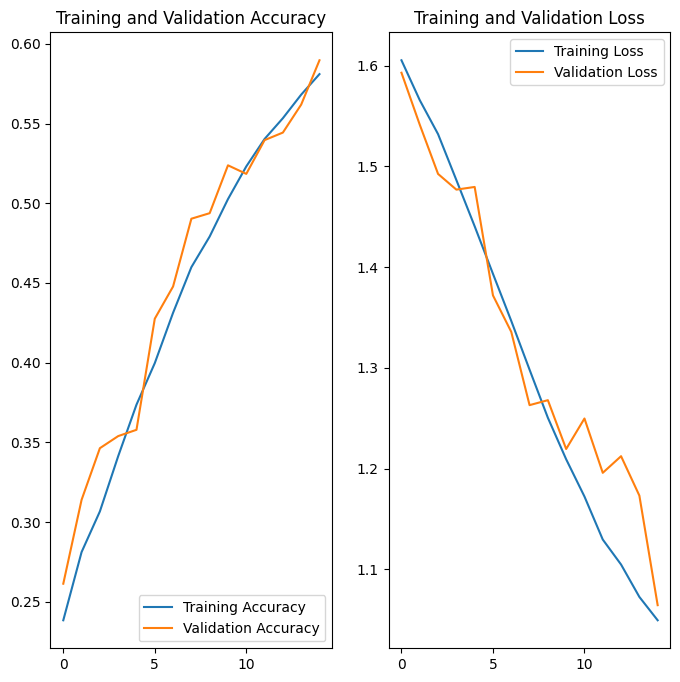

In [14]:
# plot the training results
plot_results(history)

In [17]:
new_model = load_model(os.path.join('..', 'models','large-dataset-no-segmentation-epoch15.h5'))

In [23]:
predictimgpath = os.path.join('..', 'Data', 'tests', 'porsche_test_2.jpg')

In [24]:
img = tf.keras.utils.load_img(
    predictimgpath, target_size=(img_height, img_width)
)

In [25]:
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 38ms/step
This image most likely belongs to Mercedes with a 26.10 percent confidence.
